In [20]:
import time

import wmfdata
import numpy as np
import pandas as pd
from statistics import mean
from tqdm.notebook import tqdm

import seaborn as sns
import plotly
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
from  matplotlib import animation
from matplotlib.animation import FuncAnimation

from IPython.display import HTML, Image, display, clear_output

In [21]:
spark = wmfdata.spark.get_session(type='yarn-large', app_name="inspiration-week-ml-collab")

PySpark executors will use /usr/lib/anaconda-wmf/bin/python3.


In [35]:
from pyspark.sql.functions import explode, col
import pyspark.sql.functions as F
from pyspark.sql.types import *

## Get topics list from WDQS (not comprehensive)

`?topic wdt:P31*/wdt:P279* ?nsfw`

In [23]:
## WIKIDATA
date = "20220704"
from_clause = f"from discovery.wikibase_rdf where date={date} and wiki='wikidata'"

wd = 'http://www.wikidata.org/entity/'
wdt = 'http://www.wikidata.org/prop/direct/'
p31 = wdt+'P31'
p279 = wdt+'P279'

In [24]:
nsfw_topics = ['Q291','Q496','Q608','Q5880','Q5887','Q9103','Q10791','Q10816','Q40446','Q42165','Q124490',
'Q133993','Q174471','Q181001','Q188641','Q650891','Q673203','Q843533','Q844482','Q1058795',
'Q1406501','Q2148678','Q2192288','Q3258546','Q4620674','Q11722446']

In [36]:
topic_lists = [["<"+wd+topic+">" for topic in nsfw_topics]]
print(len(topic_lists[-1]))
for _ in range(10):
    new_topic_list = spark.sql(f"""
                                SELECT subject {from_clause}
                                  and predicate IN ('<{p31}>','<{p279}>')
                                  and object IN ('<{"','".join(topic_lists[-1])}>')
                                """).toPandas()['subject'].tolist()
    topic_lists.append(new_topic_list)
    print(len(new_topic_list))

26


426


1536


5483


9221


4291


2369


460


65


5


0


In [37]:
import csv

with open("nsfw_topic_list.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(topic_lists)

In [73]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

def get_results(query, col_list):
    endpoint_url = "https://query.wikidata.org/sparql"
    user_agent = "akhatun-ctr-inspiration-week"
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    results = pd.json_normalize(results['results']['bindings'])
    
    if len(results)==0:
        return "Empty Df"
        
    col_list_value = [col+".value" for col in col_list]
    col_map = {col+".value":col for col in col_list}
    return results[col_list_value].rename(columns = col_map)

In [50]:
labels_df_list = []

for topic_list in topic_lists[:2]+topic_lists[-3:-1]:
    items = ["wd:"+topic.split("/")[-1][:-1] for topic in topic_list]
    df = get_results(f"""
                SELECT ?item ?itemLabel
                WHERE
                {{
                  VALUES ?item {{{' '.join(items)}}}
                  SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
                }}
                """, ["item", "itemLabel"])
    print(len(df))
    labels_df_list.append(df)

26
440
67
5


In [53]:
pd.set_option('display.max_rows', 500)

In [54]:
for df in labels_df_list:
    display(df.head(500))

,item,itemLabel
0,http://www.wikidata.org/entity/Q291,pornography
1,http://www.wikidata.org/entity/Q496,feces
2,http://www.wikidata.org/entity/Q608,human sexual activity
3,http://www.wikidata.org/entity/Q5880,vagina
4,http://www.wikidata.org/entity/Q5887,orgasm
5,http://www.wikidata.org/entity/Q9103,breast
6,http://www.wikidata.org/entity/Q10791,nudity
7,http://www.wikidata.org/entity/Q10816,sex toy
8,http://www.wikidata.org/entity/Q40446,nude
9,http://www.wikidata.org/entity/Q42165,buttocks


,item,itemLabel
0,http://www.wikidata.org/entity/Q6623,vibrator
1,http://www.wikidata.org/entity/Q39385,expanded orgasm
2,http://www.wikidata.org/entity/Q92162007,Erotic horror
3,http://www.wikidata.org/entity/Q64339357,Die Erde
4,http://www.wikidata.org/entity/Q509244,chyle
5,http://www.wikidata.org/entity/Q3490562,sexual stimulation
6,http://www.wikidata.org/entity/Q66563448,male nipple
7,http://www.wikidata.org/entity/Q4409738,intracellular fluid
8,http://www.wikidata.org/entity/Q910759,cow dung
9,http://www.wikidata.org/entity/Q3090525,sex machine


,item,itemLabel
0,http://www.wikidata.org/entity/Q111179376,Q111179376
1,http://www.wikidata.org/entity/Q108920987,Sexual abuse by the Society of St. Pius X
2,http://www.wikidata.org/entity/Q110888000,Q110888000
3,http://www.wikidata.org/entity/Q108940709,Q108940709
4,http://www.wikidata.org/entity/Q102231053,chum salmon fisheries
5,http://www.wikidata.org/entity/Q1143976,female homicides in Ciudad Juárez
6,http://www.wikidata.org/entity/Q109280329,Q109280329
7,http://www.wikidata.org/entity/Q107629669,murder of Keishla Rodríguez
8,http://www.wikidata.org/entity/Q7458753,Sexual abuse scandal in the Society of Jesus
9,http://www.wikidata.org/entity/Q19692665,Q19692665


,item,itemLabel
0,http://www.wikidata.org/entity/Q102231053,chum salmon fisheries
1,http://www.wikidata.org/entity/Q102230986,sockeye salmon fisheries
2,http://www.wikidata.org/entity/Q102229312,chinook salmon fisheries
3,http://www.wikidata.org/entity/Q102230897,coho salmon fisheries
4,http://www.wikidata.org/entity/Q102231024,pink salmon fisheries


I don't like doing P31\*/P279\* precisely because of this. It seems some fisheries are under nsfw? but honestly this is much better than cheese being under scholarly articles. Anyways, we can go ahead with these topics acknowledging that there are some non-nsfw things. But since these topics (for now) are not too-too much, we can glance them once to filter out some obvious non-nsfw, but thats manual work I don't think is scalable.

In [ ]:
len(topic_lists)

In [25]:
topic_lists = []

with open("nsfw_topic_list.csv", "r") as f:
    for line in f:
        topic_lists.append(line[:-1].split(','))

topic_lists = topic_lists[:-1]

In [26]:
for topic_list in topic_lists:
    print(len(topic_list))

26
426
1536
5483
9221
4291
2369
460
65
5


In [27]:
topic_lists[-1]

['<http://www.wikidata.org/entity/Q102231053>',
 '<http://www.wikidata.org/entity/Q102230986>',
 '<http://www.wikidata.org/entity/Q102229312>',
 '<http://www.wikidata.org/entity/Q102230897>',
 '<http://www.wikidata.org/entity/Q102231024>']

In [28]:
all_topics = [topic for topic_list in topic_lists for topic in topic_list]
len(all_topics)

23882

In [133]:
len(set(all_topics))

11581

In [136]:
with open("nsfw_topic_list.txt", "w") as f:
    for topic in set(all_topics):
        f.write(topic.split("/")[-1][:-1]+"\n")

## Get commons data
`?image wdt:P180 ?topic`

### With sparql? 
--> Needs login, there might be a hacky way, but I will need too many smaller queries (length of query will be too big)

In [35]:
from SPARQLWrapper import SPARQLWrapper, JSON

def get_results_commons(query, col_list):
    endpoint_url = "https://commons-query.wikimedia.org/sparql"
    user_agent = 'Aisha/Inspiration-Week (akhatun-ctr@wikimedia.org)'
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    display(results)
    results = pd.json_normalize(results['results']['bindings'])
    
    if len(results)==0:
        return "Empty Df"
        
    col_list_value = [col+".value" for col in col_list]
    col_map = {col+".value":col for col in col_list}
    return results[col_list_value].rename(columns = col_map)

In [36]:
query = """#shows M-entities that depict Douglas Adams
SELECT ?file WHERE {
  ?file wdt:P180 wd:Q496 .
}"""
results = get_results_commons(query, ["file"])
results

b'<!DOCTYPE html>\n<html class="client-nojs" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title>Log in - Wikimedia Commons</title>\n<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":true,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"57ac0f55-4a03-4fb0-9148-87cd2f0ac772","wgCSPNonce":false,"wgCanonicalNamespace":"Special","wgCanonicalSpecialPageName":"Userlogin","wgNamespaceNumber":-1,"wgPageName":"Special:UserLogin","wgTitle":"UserLogin","wgCurRevisionId":0,"wgRevisionId":0,"wgArticleId":0,"wgIsArticle":false,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":[],"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgRelevantPageName":"Special:UserLogin","wgRelevantArticleId":0,"wgIsProbablyEditable":false

TypeError: byte indices must be integers or slices, not str

### Using entity table

In [23]:
spark.sql("use structured_data")
spark.sql("show tables").show(truncate=False)

+---------------+--------------+-----------+
|database       |tableName     |isTemporary|
+---------------+--------------+-----------+
|structured_data|commons_entity|false      |
+---------------+--------------+-----------+



In [25]:
spark.table("structured_data.commons_entity").printSchema()

root
 |-- id: string (nullable = true)
 |-- typ: string (nullable = true)
 |-- labels: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- descriptions: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- statements: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- mainSnak: struct (nullable = true)
 |    |    |    |-- typ: string (nullable = true)
 |    |    |    |-- property: string (nullable = true)
 |    |    |    |-- dataType: string (nullable = true)
 |    |    |    |-- dataValue: struct (nullable = true)
 |    |    |    |    |-- typ: string (nullable = true)
 |    |    |    |    |-- value: string (nullable = true)
 |    |    |    |-- hash: string (nullable = true)
 |    |    |-- typ: string (nullable = true)
 |    |    |-- rank: string (nullable = true)
 |    |    |-- qualifiers: array (nullable = true)


In [29]:
commons_data = spark.sql("select * from structured_data.commons_entity")

In [15]:
commons_data.show(1, truncate=False, vertical=True)

[Stage 0:>                                                          (0 + 1) / 1]

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [18]:
commons_data.withColumn("statement", F.explode("statements"))\
            .drop("statements")\
            .select("statement.*")\
            .show(1, truncate=False, vertical=True)

-RECORD 0--------------------------------------------------------------------------------------------------------------
 id              | M37560874$8f9443b8-830c-11ea-b30b-7cdd905973f3                                                      
 mainSnak        | [value, P275,, [wikibase-entityid, {"entity-type":"item","numeric-id":14946043,"id":"Q14946043"}],] 
 typ             | statement                                                                                           
 rank            | normal                                                                                              
 qualifiers      | null                                                                                                
 qualifiersOrder | null                                                                                                
 references      | null                                                                                                
only showing top 1 row



In [52]:
all_images = \
        commons_data.withColumn("statement", F.explode("statements"))\
            .drop("statements")\
            .filter("statement.mainSnak.property == 'P180'")\
            .filter("statement.mainSnak.dataValue.typ == 'wikibase-entityid'")\
            .withColumn("statement_mainSnak_dataValue_value",
                        F.from_json(col("statement.mainSnak.dataValue.value"),MapType(StringType(),StringType())))\
            .select("id", 
                    "lastrevid", 
                    "statement.mainSnak.property", 
                    # "typ", # mediainfo
                    # col("statement_mainSnak_dataValue_value").getItem("entity-type").alias("entity-type"), # wikibase-entityid
                    col("statement_mainSnak_dataValue_value").getItem("id").alias("obj_id"))

In [53]:
all_images.show(10, truncate=False, vertical=True)

[Stage 27:>                                                         (0 + 1) / 1]

-RECORD 0--------------
 id        | M31369766 
 lastrevid | 594214013 
 property  | P180      
 obj_id    | Q5558497  
-RECORD 1--------------
 id        | M35128962 
 lastrevid | 538827050 
 property  | P180      
 obj_id    | Q18159964 
-RECORD 2--------------
 id        | M28497902 
 lastrevid | 589690444 
 property  | P180      
 obj_id    | Q11819421 
-RECORD 3--------------
 id        | M42950640 
 lastrevid | 537665170 
 property  | P180      
 obj_id    | Q18746275 
-RECORD 4--------------
 id        | M28921298 
 lastrevid | 535975096 
 property  | P180      
 obj_id    | Q5024893  
-RECORD 5--------------
 id        | M36822051 
 lastrevid | 623238889 
 property  | P180      
 obj_id    | Q3282626  
-RECORD 6--------------
 id        | M36822051 
 lastrevid | 623238889 
 property  | P180      
 obj_id    | Q336989   
-RECORD 7--------------
 id        | M36822051 
 lastrevid | 623238889 
 property  | P180      
 obj_id    | Q11451    
-RECORD 8--------------
 id        | M36

In [57]:
all_images.groupby("id", "obj_id").count().filter("count > 1").sort("count", ascending=False).show(10, truncate=False)

[Stage 31:=====================================================>(504 + 8) / 512]

+----------+---------+-----+
|id        |obj_id   |count|
+----------+---------+-----+
|M78932347 |Q733234  |160  |
|M69253382 |Q7368    |120  |
|M117940684|Q60634044|112  |
|M109824222|Q45354062|104  |
|M63662345 |Q188675  |96   |
|M74268697 |Q8441    |88   |
|M74274700 |Q8441    |80   |
|M46447322 |Q183061  |72   |
|M91425125 |Q2449538 |72   |
|M74328551 |Q1020994 |72   |
+----------+---------+-----+
only showing top 10 rows



In [59]:
all_dis_images = all_images.select("id", "obj_id").distinct()

In [64]:
all_topic_ids = [topic.split("/")[-1][:-1] for topic in all_topics]

nsfw_images = all_dis_images.filter(col("obj_id").isin(all_topic_ids))
nsfw_images.count(), nsfw_images.select("id").distinct().count()

(14429, 13090)

In [68]:
nsfw_images_pd = nsfw_images.toPandas()
nsfw_images_pd.to_csv("nsfw_images_pd.csv", index=False)
nsfw_images_pd

,id,obj_id
0,M60942788,Q40446
1,M115875406,Q40446
2,M114558673,Q76469
3,M60935519,Q175111
4,M60871293,Q40446
...,...,...
14424,M105862575,Q5880
14425,M118458603,Q58
14426,M60873103,Q40446
14427,M90802091,Q95965839


In [66]:
## total vs number of nsfw topics that have images
len(all_topics), nsfw_images.select("obj_id").distinct().count()

(23882, 783)

In [67]:
cat_count = nsfw_images.groupby("obj_id").count().sort("count", ascending=False).toPandas()
cat_count

,obj_id,count
0,Q40446,2980
1,Q95965839,1291
2,Q3235597,957
3,Q14373,898
4,Q36963,782
...,...,...
778,Q12829829,1
779,Q8000914,1
780,Q1022864,1
781,Q28119274,1


In [69]:
cat_count.to_csv("nsfw_cat_count.csv", index=False)

In [75]:
items = ["wd:"+item for item in cat_count['obj_id'].values.tolist()]
dfs = []

for ix in range(0,len(items),200):
    print(f"from {ix} to {ix+200}")
    items_subset = items[ix:ix+200]
    df = get_results(f"""
                    SELECT ?item ?itemLabel
                    WHERE
                    {{
                      VALUES ?item {{{' '.join(items_subset)}}}
                      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
                    }}
                    """, ["item", "itemLabel"])
    dfs.append(df)

from 0 to 200
from 200 to 400
from 400 to 600
from 600 to 800


In [79]:
cat_names = pd.concat(dfs)
cat_names['item'] = cat_names['item'].apply(lambda x: x.split("/")[-1])
cat_names

,item,itemLabel
0,Q40446,nude
1,Q95965839,George Floyd protests
2,Q3235597,crucifixion
3,Q14373,fishing
4,Q36963,hunting
...,...,...
178,Q12829829,pus
179,Q8000914,wild fisheries
180,Q1022864,Akika
181,Q28119274,Binigaus


In [85]:
cat_count_w_label= cat_count.merge(cat_names, left_on="obj_id", right_on="item").drop(columns="obj_id").rename(columns={"count":"number_of_images"})
cat_count_w_label

,number_of_images,item,itemLabel
0,2980,Q40446,nude
1,1291,Q95965839,George Floyd protests
2,957,Q3235597,crucifixion
3,898,Q14373,fishing
4,782,Q36963,hunting
...,...,...,...
778,1,Q12829829,pus
779,1,Q8000914,wild fisheries
780,1,Q1022864,Akika
781,1,Q28119274,Binigaus


In [86]:
cat_count_w_label.to_csv("nsfw_cat_count_w_label.csv", index=False)

In [88]:
nsfw_images_w_label = nsfw_images_pd.merge(cat_names, left_on="obj_id", right_on="item").drop(columns="obj_id")\
                                    .rename(columns={"id":"image_id", "item":"cat_id", "itemLabel":"cat_label"}) 
nsfw_images_w_label.to_csv("nsfw_images_w_label.csv", index=False)
nsfw_images_w_label

,image_id,cat_id,cat_label
0,M60942788,Q40446,nude
1,M115875406,Q40446,nude
2,M60871293,Q40446,nude
3,M60424131,Q40446,nude
4,M60192868,Q40446,nude
...,...,...,...
14424,M120264679,Q111181269,Murder of Patsy Morris
14425,M3126097,Q1243210,double penetration
14426,M10994821,Q7170074,Persecution of pagans in the late Roman Empire
14427,M92882173,Q19085,death of Osama bin Laden


## Get stats visu

In [89]:
nsfw_images_w_label

,image_id,cat_id,cat_label
0,M60942788,Q40446,nude
1,M115875406,Q40446,nude
2,M60871293,Q40446,nude
3,M60424131,Q40446,nude
4,M60192868,Q40446,nude
...,...,...,...
14424,M120264679,Q111181269,Murder of Patsy Morris
14425,M3126097,Q1243210,double penetration
14426,M10994821,Q7170074,Persecution of pagans in the late Roman Empire
14427,M92882173,Q19085,death of Osama bin Laden


In [90]:
cat_count_w_label

,number_of_images,item,itemLabel
0,2980,Q40446,nude
1,1291,Q95965839,George Floyd protests
2,957,Q3235597,crucifixion
3,898,Q14373,fishing
4,782,Q36963,hunting
...,...,...,...
778,1,Q12829829,pus
779,1,Q8000914,wild fisheries
780,1,Q1022864,Akika
781,1,Q28119274,Binigaus


In [94]:
len(cat_count_w_label[cat_count_w_label['number_of_images'] == 1]), \
len(cat_count_w_label[cat_count_w_label['number_of_images'] > 1])

(339, 444)

In [98]:
cat_count_w_label[cat_count_w_label['number_of_images'] > 1].head(50)

,number_of_images,item,itemLabel
0,2980,Q40446,nude
1,1291,Q95965839,George Floyd protests
2,957,Q3235597,crucifixion
3,898,Q14373,fishing
4,782,Q36963,hunting
5,357,Q9103,breast
6,277,Q58,penis
7,271,Q7873,blood
8,265,Q8124,human penis
9,245,Q10791,nudity


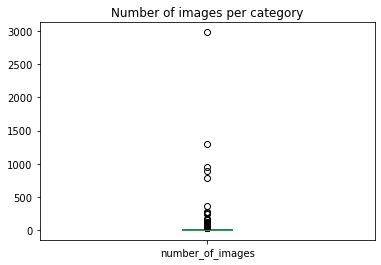

In [142]:
ax = cat_count_w_label[cat_count_w_label['number_of_images'] > 1].plot(kind="box", title="Number of images per category")
ax.get_figure().savefig('num_images_per_cat_box.png')

<AxesSubplot:xlabel='Categories', ylabel='Number of images'>

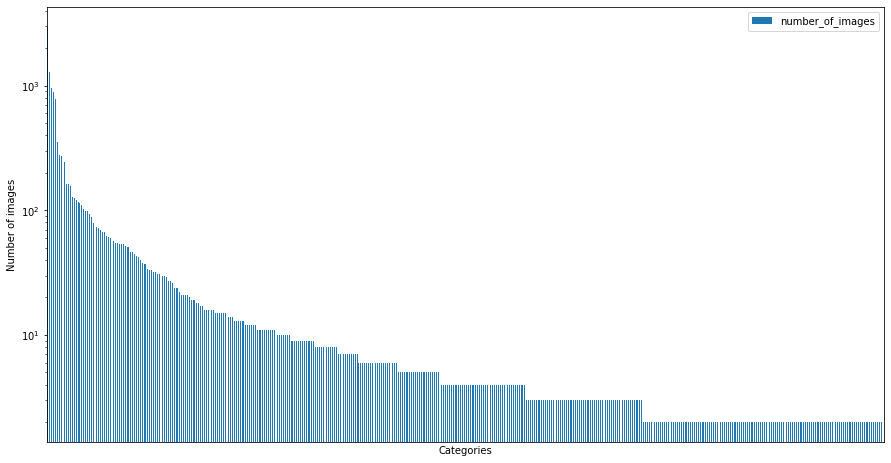

In [116]:
cat_count_w_label[cat_count_w_label['number_of_images'] > 1][['number_of_images']]\
        .plot(kind="bar", figsize=(15,8), logy=True, xticks=[], xlabel="Categories", ylabel="Number of images")

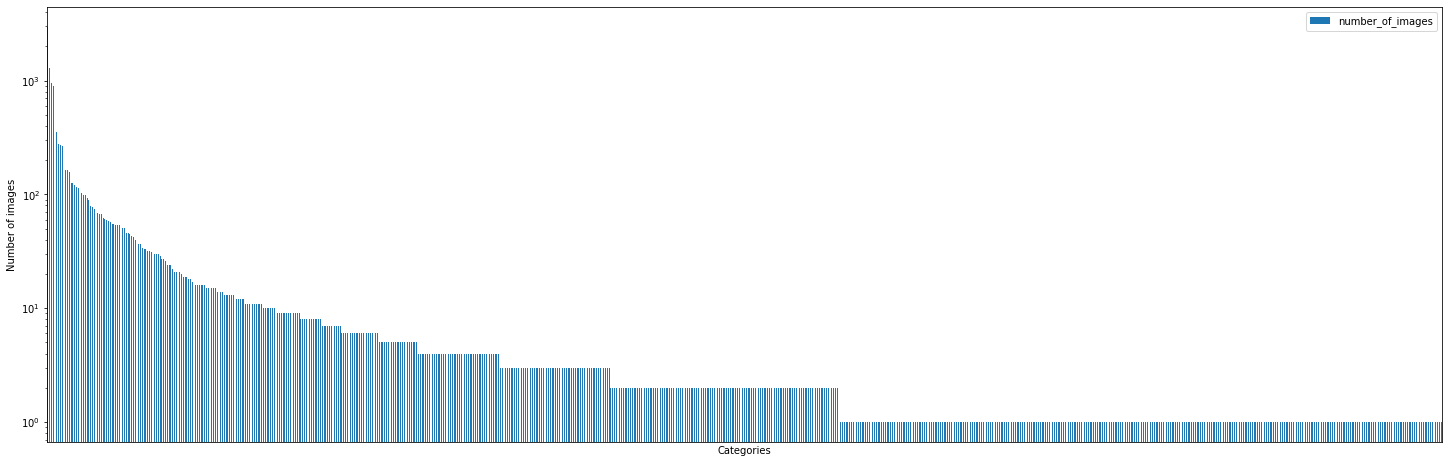

In [143]:
ax = cat_count_w_label[['number_of_images']]\
        .plot(kind="bar", figsize=(25,8), logy=True, xticks=[], xlabel="Categories", ylabel="Number of images")
ax.get_figure().savefig('num_images_per_cat_bar.png')

In [128]:
## range and number of cats vs number of images

for i in range(0, 3000, 50):
    x = i
    y = i+50
    val = len(cat_count_w_label[(cat_count_w_label['number_of_images'] >=x) &
                                (cat_count_w_label['number_of_images'] < y)])
    if val>0:
        print(f"{val} categories have [{x} to {y}) images")

739 categories have [0 to 50) images
24 categories have [50 to 100) images
7 categories have [100 to 150) images
3 categories have [150 to 200) images
1 categories have [200 to 250) images
3 categories have [250 to 300) images
1 categories have [350 to 400) images
1 categories have [750 to 800) images
1 categories have [850 to 900) images
1 categories have [950 to 1000) images
1 categories have [1250 to 1300) images
1 categories have [2950 to 3000) images
